In [2]:
# Add open_cp code to our system path,
#  and import tools from riskModelsGeneric

import sys
import os
sys.path.insert(0, os.path.abspath(".."))
import riskModelsGeneric
import importlib
importlib.reload(riskModelsGeneric)
from riskModelsGeneric import *

# Data

Choose a data directory that will contain your input and output files. (Default: "../../Data")

In that directory, you should place these files:
- Input CSV file of crime events, with these 4 columns (the expected formats can be changed as needed via additional parameters):
    - Time and date, currently expected as MM/DD/YYYY HH:MM:SS (AM/PM), as in 01/29/2001 03:36:25 PM
    - Eastings, currently expected as feet instead of meters
    - Northings, currently expected as feet instead of meters
    - Crime type, e.g. BURGLARY
    - (further columns will be ignored)
- Geojson file that will generate a polygon of the relevant region
    - For Chicago, this can be found at:
        - https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6
    - For regions of the UK, this can be made via the following process:
        - Visit https://www.ordnancesurvey.co.uk/opendatadownload/products.html
        - Scroll down to the "Boundary-Line" data, select ESRI SHAPE format, click the "Download" box, then scroll to the bottom and click "Continue".
        - After requesting the download from the next page, wait for a download link to be sent to your email, which should allow you to download a "force_kmls.zip" file full of .kml files.
        - Use the "ogr2ogr" tool to convert the relevant .kml file to .geojson, as in the following command: "ogr2ogr -f GeoJSON durham.geojson durham.kml"
        - Convert that geojson file to a new one that has a UK-specific projection (EPSG 27700); this can be done with the function convertGeojsonUKCounty in onetimeruns.py

# Set your parameters for the models here

In [3]:

# Location of data file
datadir = "../../Data"

# Dataset name (to be included in names of output files)
dataset_name = "chicago"

# Crime types, comma-separated as needed
crime_type_set = "BURGLARY"

# Size of grid cells
cell_width = 100

# Input csv file name
in_csv_file_name = "chi_all_s_BURGLARY_RES_010101_190101_stdXY.csv"

# Geojson file
geojson_file_name = "Chicago_South_Side_2790.geojson"
#geojson_file_name = "Chicago_Areas.geojson"
#geojson_file_name = "Durham_27700.geojson"

# Of all planned experiments, earliest start of a TEST (not train) data set
# Format: YYYY-MM-DD
earliest_test_date = "2003-01-01"

# Time between earliest experiment and latest experiment
test_date_range = "1W"

# Length of training data
train_len = "8W"

# Length of testing data
test_len = "1W"

# Time step offset between different experiments
# If set to None, then test_date_step = test_len (so experiments are non-overlapping)
test_date_step = None

# Coverage rates to test, comma-separated as needed
coverage_bounds = "0.01,0.02,0.05,0.10"

# Predictive models to run, comma-separated as needed
models_to_run = "random,naive,phs,ideal"

# Parameter list for Random model
#  Number of different random models to generate
num_random = 1

# Parameter list for PHS model, each one comma-separated as needed
#  Atomic unit for time bandwidths
#  Time bandwidths
#  Atomic unit for distance bandwidths in meters
#  Distance bandwidths in meters
#  Weight method (classic or linear)
phs_time_units = "1W"
phs_time_bands = "4W,6W"
phs_dist_units = "100"
phs_dist_bands = "200,300,400"
phs_weight = "classic"





# Run experiments using various models and data subsets

This function (runModelExperiments) takes the parameters from above and runs the models with all desired parameter combinations, using training and testing data sets over sliding-window timeframes.

A csv output file will appear in the defined data directory, containing results from each model with each parameter combination on each timeframe's data set.

If only 1 or 2 different data timeframes are used, heatmap visualisations will be generated, appearing below as well as in the same defined data directory.

Declaring parameters...
datadir is defined as:
..\..\Data
...declared parameters.
Obtaining full data set and region...
...obtained full data set and region.
Time taken to obtain data: 2.811933755874634
Running experiment 1/1...
num_crimes_train: 394
num_crimes_test: 46
model_name: random
parameter set #: 0
model_name: naive
parameter set #: 0
model_name: phs
parameter set #: 0
model_name: phs
parameter set #: 1
model_name: phs
parameter set #: 2
model_name: phs
parameter set #: 3
model_name: phs
parameter set #: 4
model_name: phs
parameter set #: 5
model_name: ideal
parameter set #: 0
time spent on exp: 8.076903820037842
Experiment timing info:
Exp #	Time
0	8.076903820037842


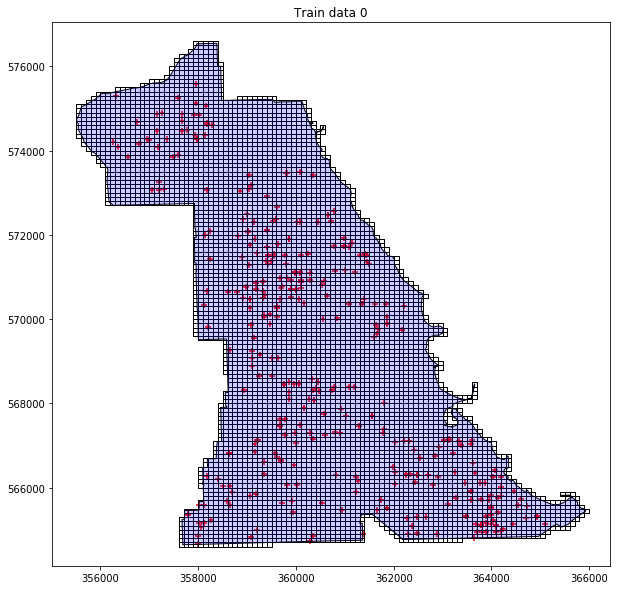

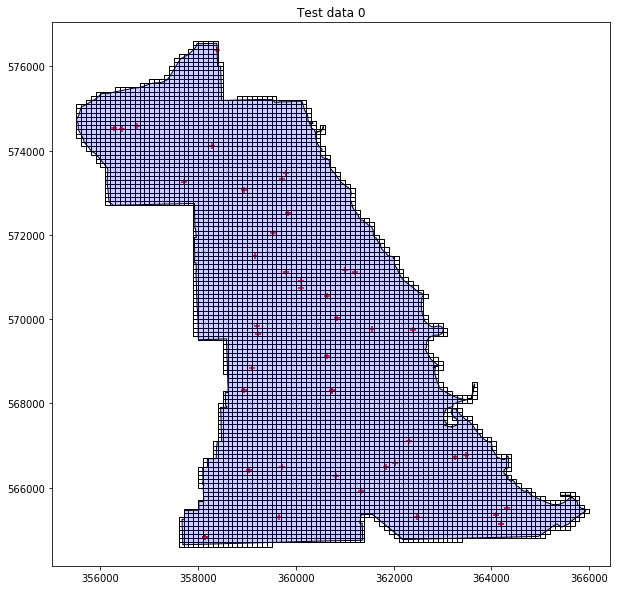

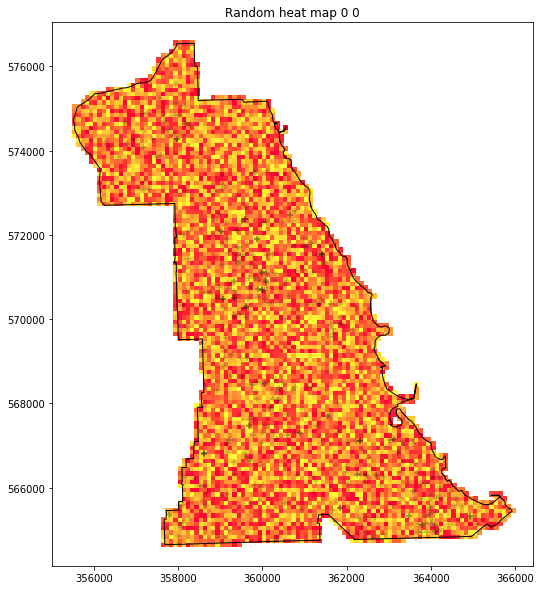

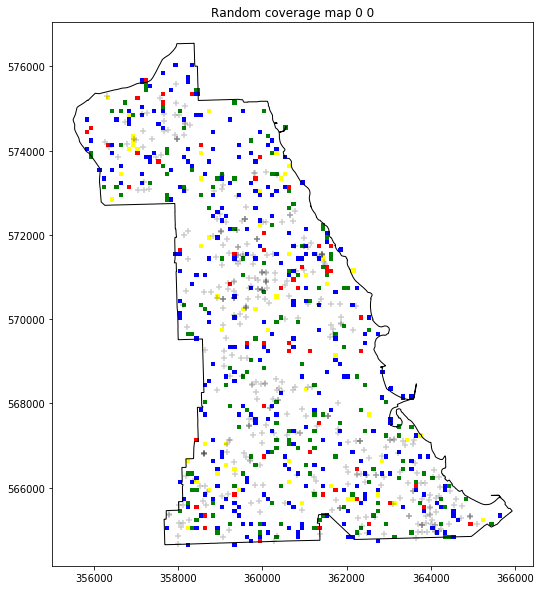

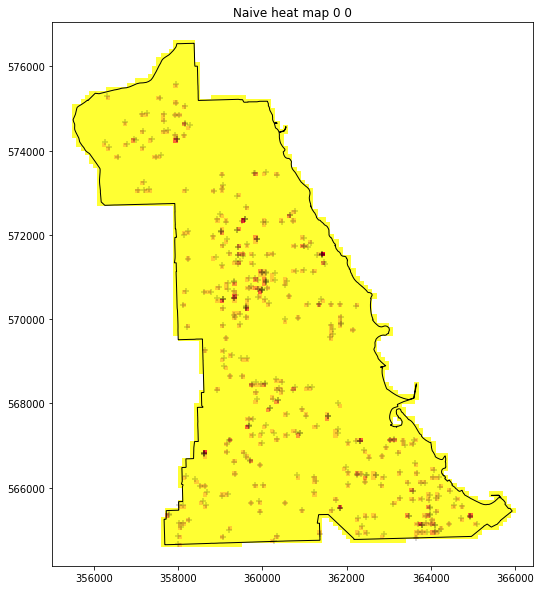

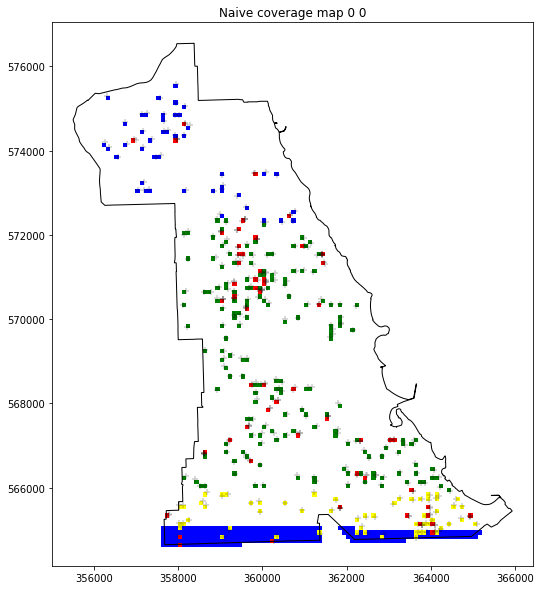

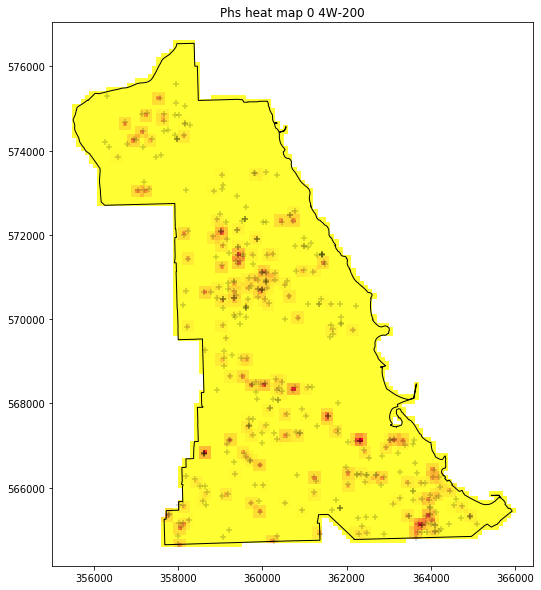

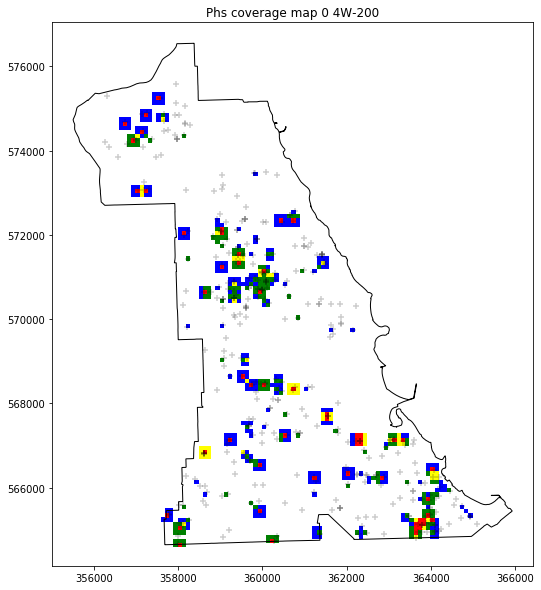

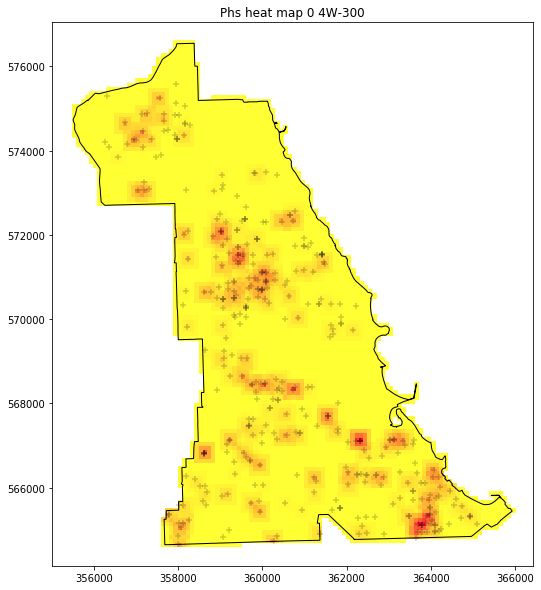

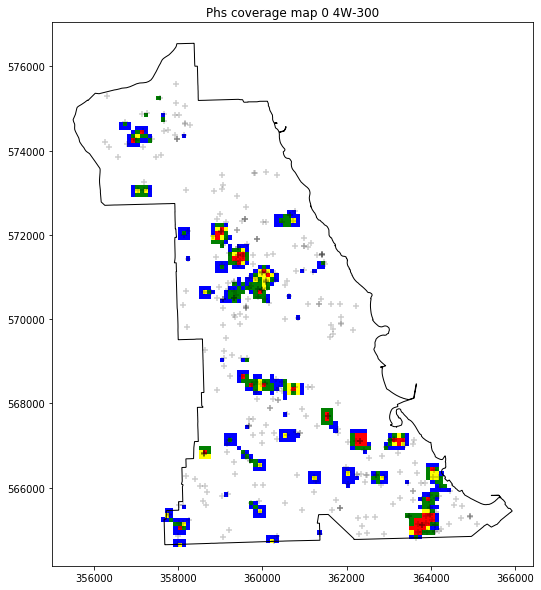

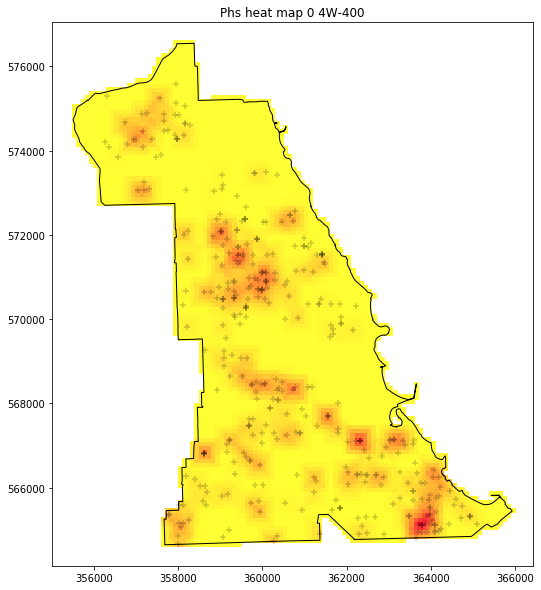

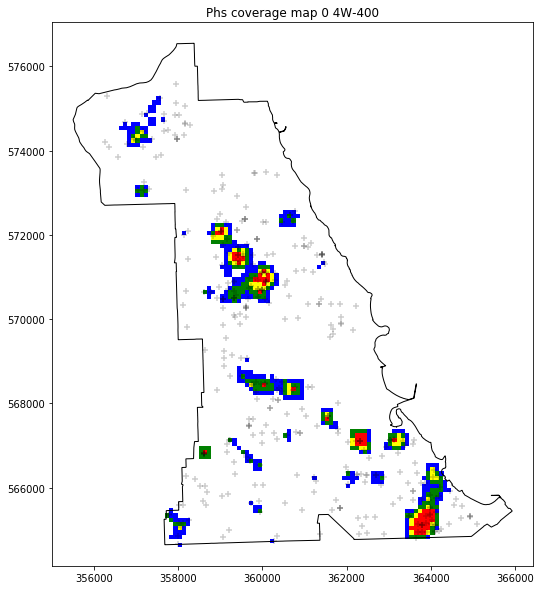

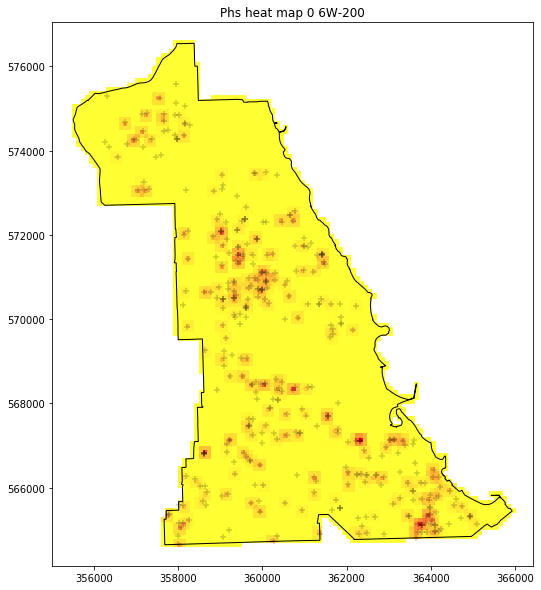

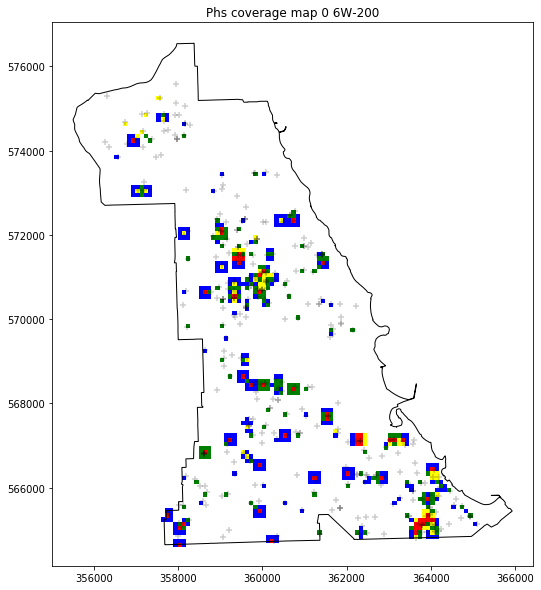

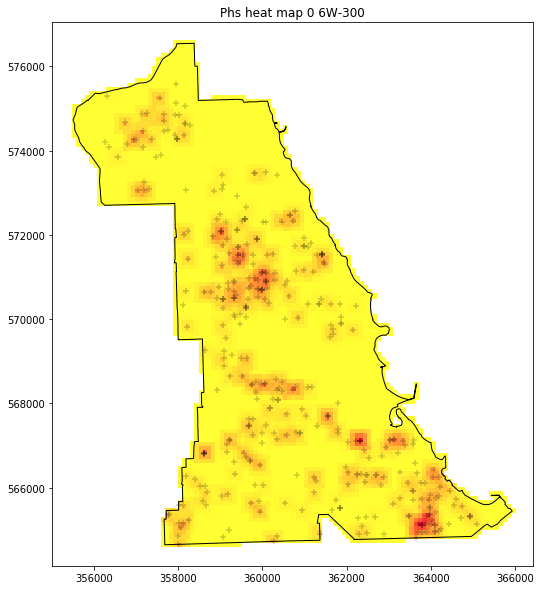

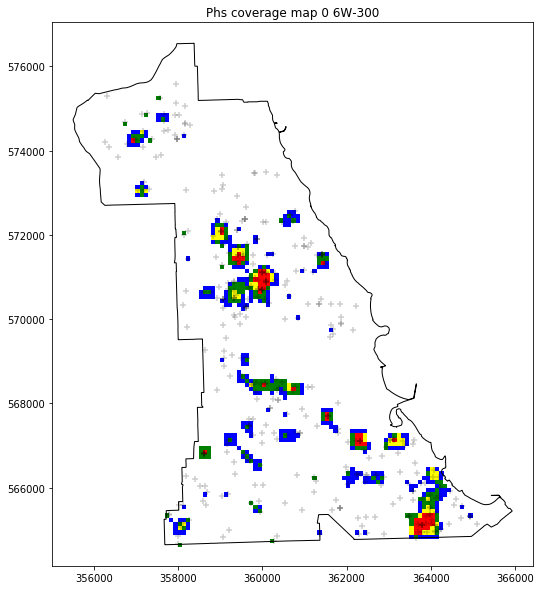

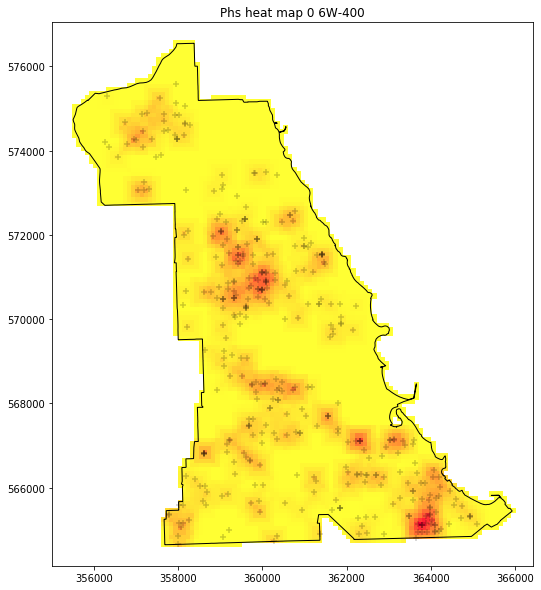

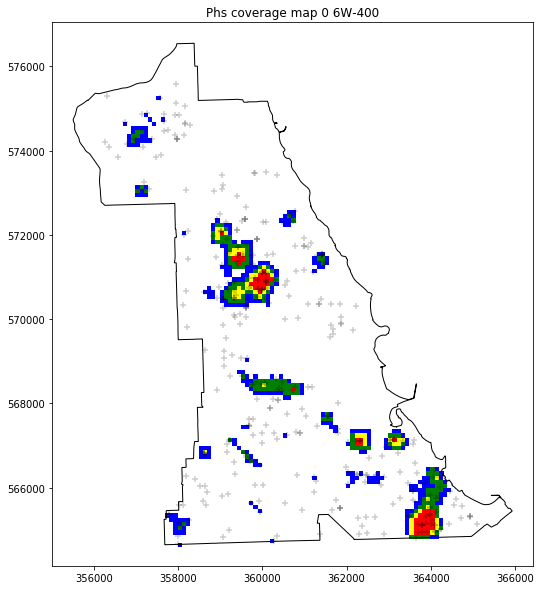

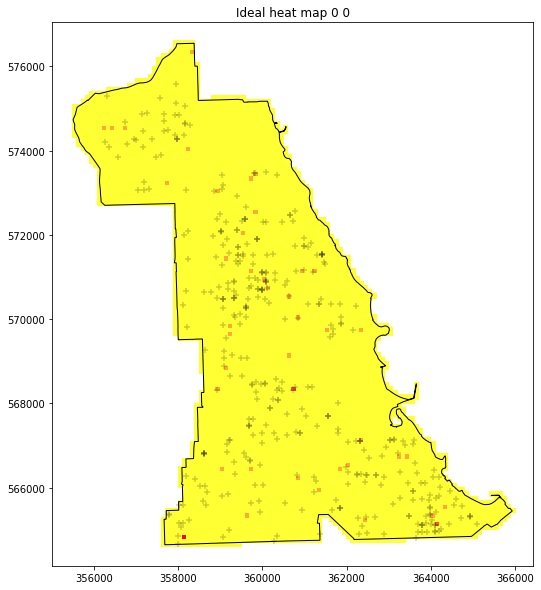

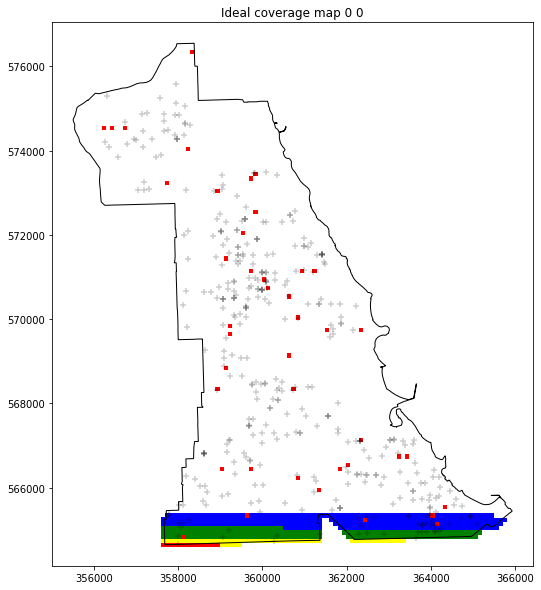

In [4]:

runModelExperiments(
        datadir_in = datadir, 
        dataset_name_in = dataset_name, 
        crime_type_set_in = crime_type_set, 
        cell_width_in = cell_width, 
        in_csv_file_name_in = in_csv_file_name, 
        geojson_file_name_in = geojson_file_name, 
        earliest_test_date_in = earliest_test_date, 
        test_date_range_in = test_date_range, 
        train_len_in = train_len, 
        test_len_in = test_len, 
        test_date_step_in = test_date_step, 
        coverage_bounds_in = coverage_bounds, 
        models_to_run_in = models_to_run, 
        num_random_in = num_random, 
        phs_time_units_in = phs_time_units, 
        phs_time_bands_in = phs_time_bands, 
        phs_dist_units_in = phs_dist_units, 
        phs_dist_bands_in = phs_dist_bands, 
        phs_weight_in = phs_weight,  
        )
